# Check Algorithm Profits

In [761]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [762]:
def trasform_ratios_to_probs(df):
    df_copy = df.copy()
    for column in df_copy.columns:
        df_copy[column] = (1/df_copy[column])
    normalization_factor = df_copy.sum(axis = 1)
    for column in df_copy.columns:
        df_copy[column] /= normalization_factor
    return df_copy

def get_naive_predictions(df):
    return pd.Series(np.array(df).argmax(axis = 1),index = df.index)

def calc_rolling_mean(df,input_column):
    series      = df[input_column]
    window_len  = len(series.index)
    temp_list   = [0] + list(series.rolling(window = window_len,min_periods = 1,center = False).mean())[0:-1]
    return pd.Series(temp_list,index = series.index)

def calc_rolling_sum(df,input_column):
    series      = df[input_column]
    window_len  = len(series.index)
    temp_list   = [0] + list(series.rolling(window = window_len,min_periods = 1,center = False).sum())[0:-1]
    return pd.Series(temp_list,index = series.index)

def get_optimal_bet_ratio(df,bet_houses,pred):
    dic = {0:"D",1:"H",2:"A"}
    temp_pred = pred.map(dic)
    temp = []
    for index in temp_pred.index:
        new_list = [x + temp_pred.at[index] for x in bet_houses]
        temp.append(df.loc[index][new_list].max())
    return pd.Series(temp,index = df.index)

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [763]:
def split_data_according_season(features, labels, test_size,random_state=None):
    X_train = {}
    X_test = {}
    y_train = {}
    y_test = {}
    
    all_leagues = features["league"].unique()
        
    for league in all_leagues:
        all_seasons = features[features["league"] == league]["season"].unique()
        
        num_of_seasons    = len(all_seasons)
        test_num_seasons  = round(num_of_seasons*test_size)
        train_num_seasons = num_of_seasons-test_num_seasons
        
        random.seed(random_state)
        random.shuffle(all_seasons)

        train_seasons = all_seasons[:train_num_seasons]
        test_seasons  = all_seasons[train_num_seasons:]

        printmd('**' + league + ':**')
        print("train_leagues =",train_seasons)
        print("test_leagues  =",test_seasons)

        X_train[league] = features[(features["league"] == league) & (features["season"].isin(train_seasons))]
        X_test[league]  = features[(features["league"] == league) & (features["season"].isin(test_seasons))]
        y_train[league] = labels[(labels["league"] == league) & (labels["season"].isin(train_seasons))]
        y_test[league]  = labels[(labels["league"] == league) & (labels["season"].isin(test_seasons))]
    
    aa = pd.concat(X_train)
    aa.index = aa.index.droplevel()
    bb = pd.concat(X_test)
    bb.index = bb.index.droplevel()
    cc = pd.concat(y_train)
    cc.index = cc.index.droplevel()
    dd = pd.concat(y_test)
    dd.index = dd.index.droplevel()
    
    return aa,bb,cc,dd

def get_split_func(split_mode):
    return {
        "according_season": split_data_according_season,
        "default":          train_test_split
    }.get(split_mode,train_test_split)

info_list = ["league","season"]

In [764]:
import numpy as np
from sklearn.decomposition import PCA

def plot_soft_decision_plan(model_name,model_predictions,real_labels):
    X = np.array([[1,0,0],[0,1,0],[0,0,1]])
    pca = PCA(n_components=2)
    pca.fit(X)

    tt = pca.transform(model_predictions)
    df = pd.DataFrame(tt,index=real_labels.index)
    df["real_labels"] = real_labels
    df["predictions"] = pd.Series(model_predictions.argmax(axis=1),index=real_labels.index)

    fig, (ax1, ax2) = plt.subplots(figsize = (20, 6), ncols = 2, sharey = True)
    fig.suptitle(model_name,fontsize=22)
    ax1.set_title("real_labels", fontsize = 18)
    ax2.set_title("predictions", fontsize = 18)
    
    colors = {0:'red', 1:'blue', 2:'green'}

    grouped = df.groupby('real_labels')
    for key, group in grouped:
        group.plot(ax=ax1, kind='scatter', x=0, y=1, label=key, color=colors[key])
        
    grouped = df.groupby('predictions')
    for key, group in grouped:
        group.plot(ax=ax2, kind='scatter', x=0, y=1, label=key, color=colors[key])

    plt.show()

In [765]:
matches = pd.read_csv("databases/my_matches_db.csv",encoding='latin-1', index_col = [0], skipinitialspace = True)
matches.head()

,league,season,stage,home_team_name,away_team_name,score,home_points,home_norm_points,home_position,home_straight_wins,...,B365H,WHH,VCH,B365A,WHA,VCA,B365D,WHD,VCD,win_lose_draw
0,England Premier League,2008/2009,1,Manchester United,Newcastle United,1 - 1,0.0,0.0,0.0,0.0,...,1.29,1.25,1.28,11.00,10.00,12.00,5.5,4.5,5.5,0
1,England Premier League,2008/2009,1,Arsenal,West Bromwich Albion,1 - 0,0.0,0.0,0.0,0.0,...,1.20,1.17,1.25,15.00,12.00,13.00,6.5,5.5,6.0,1
2,England Premier League,2008/2009,1,Sunderland,Liverpool,0 - 1,0.0,0.0,0.0,0.0,...,5.50,5.50,5.50,1.67,1.57,1.65,3.6,3.3,3.8,2
3,England Premier League,2008/2009,1,West Ham United,Wigan Athletic,2 - 1,0.0,0.0,0.0,0.0,...,1.91,1.83,1.90,4.20,3.75,4.35,3.4,3.2,3.5,1
4,England Premier League,2008/2009,1,Aston Villa,Manchester City,4 - 2,0.0,0.0,0.0,0.0,...,1.91,1.91,1.90,4.33,3.50,4.35,3.4,3.2,3.5,1


In [766]:
all_models = ["DecisionTreeClassifier","KNeighborsClassifier","LogisticRegression","RandomForestClassifier","SVC","nn_model","lstm_model","final_soft_decision"]

my_predictions = {}

for model in all_models:
    my_predictions[model] = pd.read_csv("databases/my_predictions/" + model + ".csv", index_col = [0], skipinitialspace = True)
    
my_predictions[model].head()

,MYD,MYH,MYA
2320,0.356079,0.218715,0.425206
2321,0.342326,0.279900,0.377775
2322,0.280953,0.564390,0.154657
2323,0.302073,0.154767,0.543160
2324,0.349795,0.292188,0.358017


### Betting odds features

In [767]:
b365_features = ["B365D","B365H","B365A"]
wh_features   = ["WHD","WHH","WHA"]
vc_features   = ["VCD","VCH","VCA"]
my_features   = ["MYD","MYH","MYA"]

bet_houses    = ["B365","WH","VC"]

current_bet   = my_features

In [768]:
matches[my_features] = my_predictions["RandomForestClassifier"]

In [769]:
predictions_models_names = all_models + bet_houses

In [770]:
new_matches = matches.dropna(axis = 0)

In [771]:
new_matches

,league,season,stage,home_team_name,away_team_name,score,home_points,home_norm_points,home_position,home_straight_wins,...,B365A,WHA,VCA,B365D,WHD,VCD,win_lose_draw,MYD,MYH,MYA
2320,England Premier League,2014/2015,5,Aston Villa,Arsenal,0 - 3,10.0,0.833333,2.0,2.0,...,1.85,1.83,1.87,3.60,3.40,3.70,2,0.333925,0.155743,0.510332
2321,England Premier League,2014/2015,5,Burnley,Sunderland,0 - 0,2.0,0.166667,18.0,0.0,...,3.10,2.80,3.12,3.30,3.20,3.20,0,0.357754,0.277509,0.364737
2322,England Premier League,2014/2015,5,Everton,Crystal Palace,2 - 3,5.0,0.416667,11.0,1.0,...,9.00,8.00,9.50,5.00,4.50,5.00,2,0.243317,0.630132,0.126551
2323,England Premier League,2014/2015,5,Leicester City,Manchester United,5 - 3,5.0,0.416667,12.0,1.0,...,1.67,1.67,1.67,4.20,3.50,4.00,1,0.272322,0.135037,0.592641
2324,England Premier League,2014/2015,5,Manchester City,Chelsea,1 - 1,7.0,0.583333,5.0,0.0,...,3.10,3.10,3.10,3.50,3.10,3.50,0,0.356190,0.273887,0.369923
2325,England Premier League,2014/2015,5,Newcastle United,Hull City,2 - 2,2.0,0.166667,20.0,0.0,...,3.75,3.40,3.75,3.30,3.20,3.30,0,0.359743,0.341864,0.298393
2326,England Premier League,2014/2015,5,Queens Park Rangers,Stoke City,2 - 2,3.0,0.250000,16.0,0.0,...,2.80,2.80,2.80,3.25,3.00,3.10,0,0.372980,0.262408,0.364612
2327,England Premier League,2014/2015,5,Swansea City,Southampton,0 - 1,9.0,0.750000,3.0,0.0,...,3.10,2.80,3.10,3.30,3.25,3.30,2,0.382128,0.257378,0.360494
2328,England Premier League,2014/2015,5,Tottenham Hotspur,West Bromwich Albion,0 - 1,7.0,0.583333,6.0,0.0,...,7.00,7.00,7.00,4.33,3.75,4.33,2,0.306414,0.521720,0.171866
2329,England Premier League,2014/2015,5,West Ham United,Liverpool,3 - 1,4.0,0.333333,13.0,0.0,...,1.85,1.85,1.85,3.80,3.30,3.90,1,0.263462,0.164580,0.571958


###  Features with nan values

In [772]:
max_bet_per_match = 500

In [773]:
matches_betting_odds_features = new_matches[info_list + current_bet].dropna(axis = 0)

if current_bet != my_features:
    matches_betting_odds_features[current_bet] = trasform_ratios_to_probs(matches_betting_odds_features[current_bet])
    
new_matches["predictions"] = get_naive_predictions(matches_betting_odds_features[current_bet])

matches_betting_odds_features["predictions"] = new_matches["predictions"]
matches_betting_odds_features["real_score"]  = new_matches['win_lose_draw']
matches_betting_odds_features["right_wrong"] = pd.Series(matches_betting_odds_features["real_score"] == matches_betting_odds_features["predictions"],dtype = int)
matches_betting_odds_features["bet_ratio"]   = get_optimal_bet_ratio(new_matches,bet_houses,matches_betting_odds_features["predictions"])

matches_betting_odds_features.head()

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,league,season,MYD,MYH,MYA,predictions,real_score,right_wrong,bet_ratio
2320,England Premier League,2014/2015,0.333925,0.155743,0.510332,2,2,1,1.87
2321,England Premier League,2014/2015,0.357754,0.277509,0.364737,2,0,0,3.12
2322,England Premier League,2014/2015,0.243317,0.630132,0.126551,1,2,0,1.40
2323,England Premier League,2014/2015,0.272322,0.135037,0.592641,2,1,0,1.67
2324,England Premier League,2014/2015,0.356190,0.273887,0.369923,2,0,0,3.10


In [774]:
new_matches_betting_odds_features = matches_betting_odds_features.drop(["predictions","real_score"],axis = 1)

In [775]:
new_matches_betting_odds_features.head()

,league,season,MYD,MYH,MYA,right_wrong,bet_ratio
2320,England Premier League,2014/2015,0.333925,0.155743,0.510332,1,1.87
2321,England Premier League,2014/2015,0.357754,0.277509,0.364737,0,3.12
2322,England Premier League,2014/2015,0.243317,0.630132,0.126551,0,1.40
2323,England Premier League,2014/2015,0.272322,0.135037,0.592641,0,1.67
2324,England Premier League,2014/2015,0.356190,0.273887,0.369923,0,3.10


In [776]:
right_wrong_mean_before = calc_rolling_mean(new_matches_betting_odds_features,"right_wrong")

In [777]:
new_features = new_matches_betting_odds_features.drop(["right_wrong"],axis = 1)
new_lables   = new_matches_betting_odds_features[info_list + ["right_wrong"]]

In [778]:
new_features.columns = ['league', 'season', '0', '1', '2', 'bet_ratio']

### Spliting the data 

In [779]:
from sklearn.model_selection import train_test_split

In [780]:
split_mode  = "according_season" #"default/according_season"
test_size   = 0.40
seed        = None#101

In [781]:
X_train_outer, X_test_outer, y_train_outer, y_test_outer = get_split_func(split_mode)(new_features, new_lables, test_size = test_size, random_state = seed)

**England Premier League:**

train_leagues = ['2015/2016']
test_leagues  = ['2014/2015']


**France Ligue 1:**

train_leagues = ['2013/2014']
test_leagues  = ['2012/2013']


**Germany 1. Bundesliga:**

train_leagues = ['2015/2016']
test_leagues  = ['2014/2015']


**Netherlands Eredivisie:**

train_leagues = ['2008/2009']
test_leagues  = ['2011/2012']


**Spain LIGA BBVA:**

train_leagues = ['2011/2012']
test_leagues  = ['2009/2010']


In [782]:
X_train_outer = X_train_outer[["0","1","2","bet_ratio"]]
X_test_outer  = X_test_outer[["0","1","2","bet_ratio"]]
y_train_outer = y_train_outer["right_wrong"]
y_test_outer  = y_test_outer["right_wrong"]

In [783]:
X_train_outer.drop("bet_ratio",axis = 1,inplace = True)

In [784]:
X_train_inner, X_test_inner, y_train_inner, y_test_inner = train_test_split(X_train_outer, y_train_outer, test_size = 0.30, random_state = seed)

In [785]:
from sklearn.linear_model import LogisticRegression

In [786]:
logmodel = LogisticRegression()
logmodel.fit(X_train_inner,y_train_inner)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [787]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train_inner,y_train_inner)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [788]:
chosen_model = logmodel
predictions  = chosen_model.predict(X_test_inner)

In [789]:
from sklearn.metrics import classification_report,confusion_matrix

In [790]:
printmd('**classification_report:**')
print(classification_report(y_test_inner,predictions))
printmd('**confusion_matrix:**')
print(confusion_matrix(y_test_inner,predictions))

**classification_report:**

             precision    recall  f1-score   support

          0       0.59      0.86      0.70       240
          1       0.72      0.37      0.49       226

avg / total       0.65      0.62      0.60       466



**confusion_matrix:**

[[207  33]
 [143  83]]


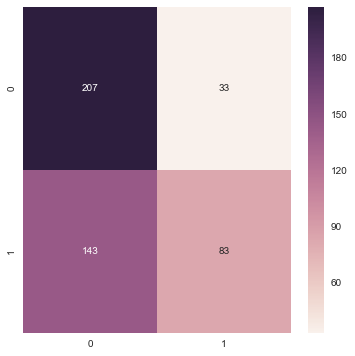

In [791]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test_inner,predictions),annot=True, fmt="d")

In [792]:
coeff_df = pd.DataFrame(logmodel.coef_.T,X_train_inner.columns)
coeff_df

,0
0,-4.233572
1,2.826312
2,1.304289


In [793]:
def get_optimal_bet(df,model,max_bet):
    #return pd.Series(df.max(axis=1)*max_bet,index = df.index)
    #return pd.Series(model.predict(df)*df.max(axis=1)*max_bet,index = df.index)
    return pd.Series(np.maximum((model.predict_proba(df) - 0.5)*2,0).T[1] * max_bet,index = df.index)

In [794]:
X_test_outer["bet"] = get_optimal_bet(X_test_outer.drop("bet_ratio",axis = 1),chosen_model,max_bet_per_match)

In [795]:
X_test_outer["right_wrong"] = y_test_outer

In [796]:
X_test_outer.head()

,0,1,2,bet_ratio,bet,right_wrong
2320,0.333925,0.155743,0.510332,1.87,0.000000,1
2321,0.357754,0.277509,0.364737,3.12,0.000000,0
2322,0.243317,0.630132,0.126551,1.40,192.735498,0
2323,0.272322,0.135037,0.592641,1.67,0.000000,0
2324,0.356190,0.273887,0.369923,3.10,0.000000,0


In [797]:
games_worth_betting = X_test_outer[X_test_outer["bet"] > 0]

In [798]:
right_wrong_mean_after = calc_rolling_mean(games_worth_betting,"right_wrong")

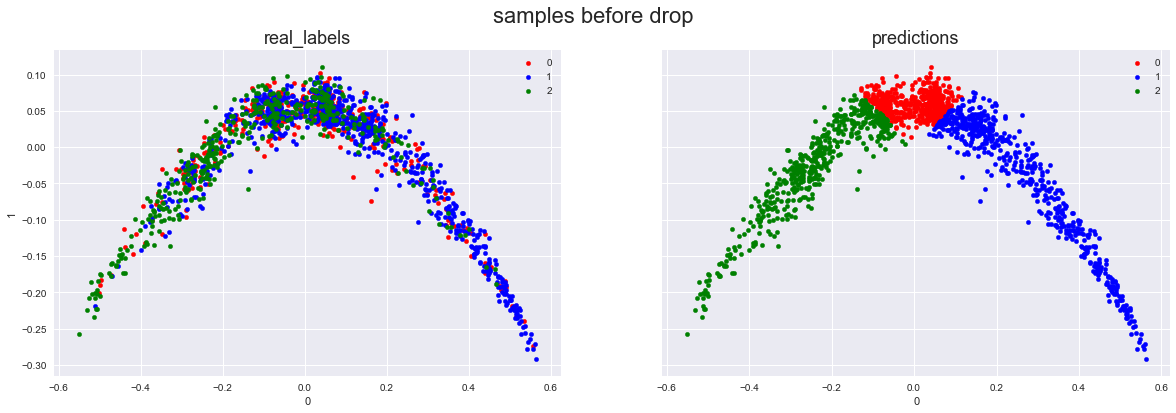

In [799]:
plot_soft_decision_plan("samples before drop",np.array(X_test_outer[["0","1","2"]]),matches_betting_odds_features.loc[X_test_outer.index]["real_score"])

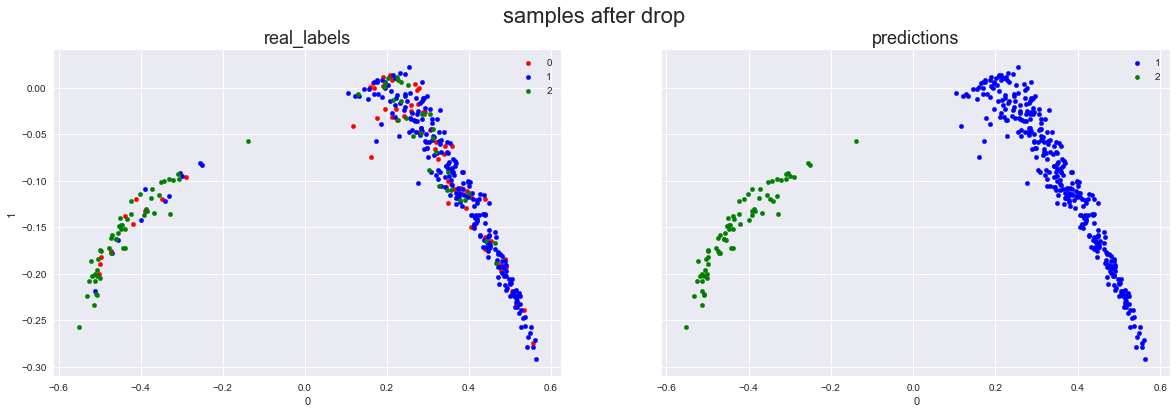

In [800]:
plot_soft_decision_plan("samples after drop",np.array(games_worth_betting[["0","1","2"]]),matches_betting_odds_features.loc[games_worth_betting.index]["real_score"])

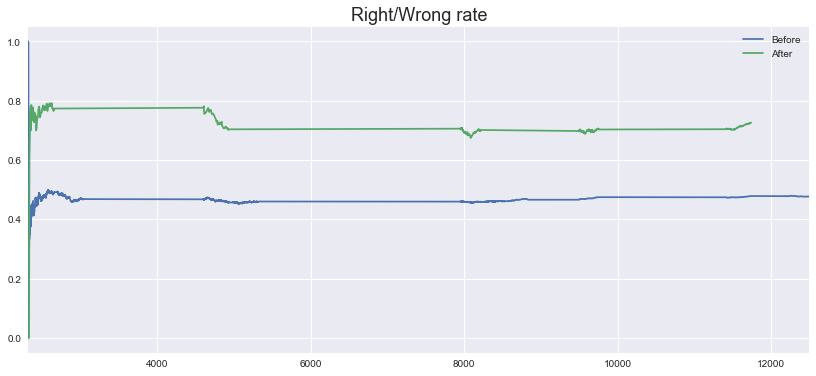

In [801]:
fig,ax = plt.subplots(figsize = (14, 6))
ax.set_title("Right/Wrong rate", fontsize = 18)

right_wrong_mean_before.plot()
right_wrong_mean_after.plot()
    
ax.legend(["Before","After"])

In [802]:
games_worth_betting["profit"] = games_worth_betting["right_wrong"]*(games_worth_betting["bet"]*games_worth_betting["bet_ratio"])-(games_worth_betting["bet"])

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [803]:
basic_info = ["season","stage","home_team_name","away_team_name","score","predictions"]
bet_info   = ["right_wrong","bet_ratio","bet","profit"]

all_bets                         = new_matches.loc[games_worth_betting.index][basic_info].sort_index()
all_bets[bet_info]               = games_worth_betting[bet_info]
all_bets["profit_through_time"]  = calc_rolling_sum(all_bets,"profit")
all_bets["invest_through_time"]  = calc_rolling_sum(all_bets,"bet")

all_bets.reset_index(drop=True,inplace=True)

all_bets.head()

,season,stage,home_team_name,away_team_name,score,predictions,right_wrong,bet_ratio,bet,profit,profit_through_time,invest_through_time
0,2014/2015,5,Everton,Crystal Palace,2 - 3,1,0,1.40,192.735498,-192.735498,0.000000,0.000000
1,2014/2015,5,Tottenham Hotspur,West Bromwich Albion,0 - 1,1,0,1.53,74.078344,-74.078344,-192.735498,192.735498
2,2014/2015,6,Chelsea,Aston Villa,3 - 0,1,1,1.25,232.405619,58.101405,-266.813842,266.813842
3,2014/2015,6,Hull City,Manchester City,2 - 4,2,1,1.57,1.839027,1.048245,-208.712438,499.219462
4,2014/2015,6,Manchester United,West Ham United,2 - 1,1,1,1.40,198.314197,79.325679,-207.664192,501.058489


In [804]:
print("Mean Bet             =", all_bets["bet"].mean(),"$")
print("Max  Bet             =", all_bets["bet"].max(),"$")
print("Min  Bet             =", all_bets["bet"].min(),"$","\n")
print("Mean Profit          =", all_bets["profit"].mean(),"$")
print("Max  Profit          =", all_bets["profit"].max(),"$")
print("Min  Profit          =", all_bets["profit"].min(),"$","\n")
print("Total Money Invested =", all_bets["bet"].sum(),"$")
print("Profits              =", all_bets["profit"].sum(),"$")
print("Profit Percentage    =",(all_bets["profit"].sum()/all_bets["bet"].sum())*100,"%")

Mean Bet             = 149.4970429906903 $
Max  Bet             = 377.369447745 $
Min  Bet             = 0.636506252932 $ 

Mean Profit          = -0.04879474364264172 $
Max  Profit          = 92.5532809128 $
Min  Profit          = -366.519656914 $ 

Total Money Invested = 60247.30832524818 $
Profits              = -19.664281687984612 $
Profit Percentage    = -0.032639270092907686 %


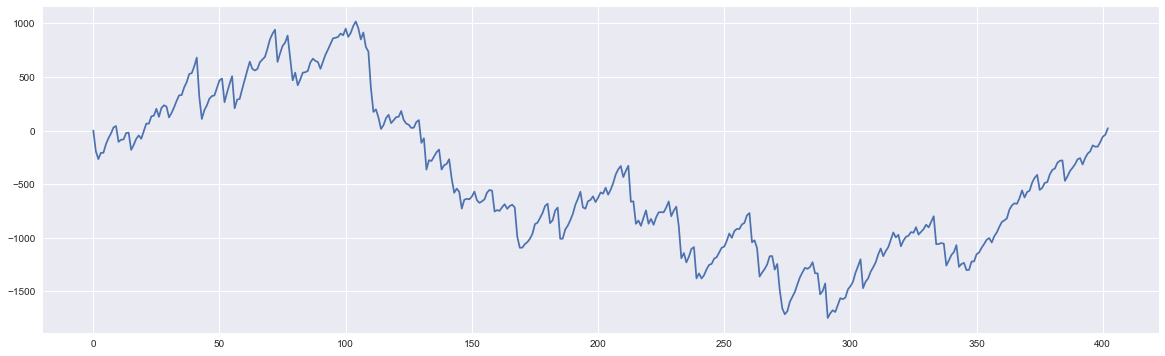

In [805]:
plt.figure(figsize=(20, 6))
plt.plot(all_bets.index,all_bets["profit_through_time"])

### Calculating profits for all models


In [806]:
basic_info = ["season","stage","home_team_name","away_team_name","score","predictions"]
bet_info   = ["right_wrong","bet_ratio","bet","profit"]
betting_house_dic = {"B365":b365_features, "WH":wh_features, "VC":vc_features }

right_wrong_ratio_before = {}
right_wrong_ratio_after  = {}

def calc_model_profit(model_name,matches,my_features,current_bet,max_bet_per_match,bet_model_name):
    if model_name in bet_houses:
        current_bet = betting_house_dic[model_name]
    else:
        matches[my_features] = my_predictions[model_name]

    new_matches = matches.dropna(axis = 0)
    
    matches_betting_odds_features = new_matches[current_bet].dropna(axis = 0)

    if current_bet != my_features:
        matches_betting_odds_features = trasform_ratios_to_probs(matches_betting_odds_features)

    new_matches["predictions"] = get_naive_predictions(matches_betting_odds_features[current_bet])

    matches_betting_odds_features["predictions"] = new_matches["predictions"]
    matches_betting_odds_features["real_score"]  = new_matches['win_lose_draw']
    matches_betting_odds_features["right_wrong"] = pd.Series(matches_betting_odds_features["real_score"] == matches_betting_odds_features["predictions"],dtype = int)
    matches_betting_odds_features["bet_ratio"]   = get_optimal_bet_ratio(new_matches,bet_houses,matches_betting_odds_features["predictions"])

    right_wrong_ratio_before[model_name] = (matches_betting_odds_features["right_wrong"].sum(),len(matches_betting_odds_features["right_wrong"]))
    
    new_matches_betting_odds_features = matches_betting_odds_features.drop(["predictions","real_score"],axis = 1)
    
    new_features = new_matches_betting_odds_features.drop(["right_wrong"],axis = 1)
    new_lables   = new_matches_betting_odds_features["right_wrong"]
    
    X_train_outer, X_test_outer, y_train_outer, y_test_outer = train_test_split(new_features, new_lables, test_size = 0.30, random_state = seed)
    X_train_outer.drop("bet_ratio",axis = 1,inplace = True)
    
    X_train_inner, X_test_inner, y_train_inner, y_test_inner = train_test_split(X_train_outer, y_train_outer, test_size = 0.30, random_state = seed)
    
    if bet_model_name == "LogisticRegression":
        bet_model = LogisticRegression()
    else:
        bet_model = RandomForestClassifier(n_estimators=600)    
    bet_model.fit(X_train_inner,y_train_inner)   
    predictions  = bet_model.predict(X_test_inner)
    
    X_test_outer["bet"] = get_optimal_bet(X_test_outer.drop("bet_ratio",axis = 1),bet_model,max_bet_per_match)
    X_test_outer["right_wrong"] = y_test_outer
    games_worth_betting = X_test_outer[X_test_outer["bet"] > 0]
    
    right_wrong_ratio_after[model_name] = (games_worth_betting["right_wrong"].sum(),len(games_worth_betting["right_wrong"]))
    
    games_worth_betting["profit"] = games_worth_betting["right_wrong"]*(games_worth_betting["bet"]*games_worth_betting["bet_ratio"])-(games_worth_betting["bet"])
    
    all_bets                         = new_matches.loc[games_worth_betting.index][basic_info].sort_index()
    all_bets[bet_info]               = games_worth_betting[bet_info]
    all_bets["profit_through_time"]  = calc_rolling_sum(all_bets,"profit")
    all_bets["invest_through_time"]  = calc_rolling_sum(all_bets,"bet")

    all_bets.reset_index(drop=True,inplace=True)

    Mean_Bet             = all_bets["bet"].mean()
    Max_Bet              = all_bets["bet"].max()
    Min_Bet              = all_bets["bet"].min()
    Mean_Profit          = all_bets["profit"].mean()
    Max_Profit           = all_bets["profit"].max()
    Min_Profit           = all_bets["profit"].min()
    Total_Money_Invested = all_bets["bet"].sum()
    Profits              = all_bets["profit"].sum()
    Profit_Percentage    =(all_bets["profit"].sum()/all_bets["bet"].sum())*100 
    
    profit_stat = np.array([[Mean_Bet, Max_Bet, Min_Bet, Mean_Profit, Max_Profit, Min_Profit, Total_Money_Invested, Profits, Profit_Percentage]])
    profit_stat_names = ["Mean Bet", "Max Bet", "Min Bet", "Mean Profit", "Max Profit", "Min Profit", "Total Money Invested", "Profits", "Profit Percentage"]
    profit_stat_df = pd.DataFrame(profit_stat,index=[model_name],columns=profit_stat_names)

    return (all_bets,profit_stat_df)

In [807]:
all_bets_all_models = {}
profit_stat_all_models_dic = {}
profit_stat_all_models = pd.DataFrame()
for model in predictions_models_names:
    all_bets_all_models[model],profit_stat_all_models_dic[model] = calc_model_profit(model,matches,my_features,current_bet,max_bet_per_match,"RandomForestClassifier")
    frames = [profit_stat_all_models, profit_stat_all_models_dic[model]]
    profit_stat_all_models = pd.concat(frames)

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

In [808]:
categorical_rate = {}
x = ["Before","After"]

for ind,df in enumerate([right_wrong_ratio_before,right_wrong_ratio_after]):
    categorical_rate[x[ind]]          = pd.DataFrame(df).T
    categorical_rate[x[ind]].columns  = ["right_guesses","total_num_games"]
    categorical_rate[x[ind]]["ratio"] = categorical_rate[x[ind]]["right_guesses"]/categorical_rate[x[ind]]["total_num_games"]

cc = pd.concat(categorical_rate, axis = 1)

In [809]:
cc.sort_values([("After", 'ratio')], ascending=False)

After                                  Before  \
                       right_guesses total_num_games     ratio right_guesses   
DecisionTreeClassifier           233             356  0.654494          1387   
final_soft_decision              244             400  0.610000          1481   
B365                             305             507  0.601578          1671   
RandomForestClassifier           239             398  0.600503          1487   
VC                               300             502  0.597610          1669   
lstm_model                       234             394  0.593909          1443   
WH                               287             497  0.577465          1667   
KNeighborsClassifier             193             337  0.572700          1379   
nn_model                         244             437  0.558352          1517   
LogisticRegression               238             430  0.553488          1472   
SVC                              232             422  0.549763          1460   

                                                  
                       total_num_games     ratio  
DecisionTreeClassifier            3113  0.445551  
final_soft_decision               3113  0.475747  
B365                              3113  0.536781  
RandomForestClassifier            3113  0.477674  
VC                                3113  0.536139  
lstm_model                        3113  0.463540  
WH                                3113  0.535496  
KNeighborsClassifier              3113  0.442981  
nn_model                          3113  0.487311  
LogisticRegression                3113  0.472856  
SVC                               3113  0.469001

In [810]:
profit_stat_all_models.sort_values("Profits",ascending=False)

,Mean Bet,Max Bet,Min Bet,Mean Profit,Max Profit,Min Profit,Total Money Invested,Profits,Profit Percentage
lstm_model,223.963621,500.0000,1.666667,9.988748,1054.166667,-470.000000,88241.666667,3935.566667,4.459987
RandomForestClassifier,240.046064,500.0000,1.666667,7.536097,923.833333,-500.000000,95538.333333,2999.366667,3.139438
final_soft_decision,234.991667,500.0000,1.666667,4.485583,762.833333,-493.333333,93996.666667,1794.233333,1.908827
nn_model,295.167811,500.0000,1.666667,3.833486,1136.666667,-500.000000,128988.333333,1675.233333,1.298748
VC,246.649686,500.0000,0.041667,1.659613,710.250000,-500.000000,123818.142126,833.125538,0.672862
KNeighborsClassifier,222.881958,500.0000,0.848124,-2.716153,782.148936,-496.008616,75111.219906,-915.343469,-1.218651
SVC,205.473934,490.0000,1.666667,-4.316746,705.333333,-450.000000,86710.000000,-1821.666667,-2.100873
DecisionTreeClassifier,185.428523,478.0401,52.799362,-7.364670,177.455227,-478.040100,66012.554340,-2621.822693,-3.971703
LogisticRegression,232.647287,500.0000,1.666667,-11.409612,700.000000,-496.666667,100038.333333,-4906.133333,-4.904253
WH,241.218710,500.0000,0.493087,-11.391233,526.686111,-500.000000,119885.698935,-5661.442737,-4.722367


In [811]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
cmap = ListedColormap(['r', 'g'])
norm = BoundaryNorm([-np.inf, 0, np.inf], cmap.N)

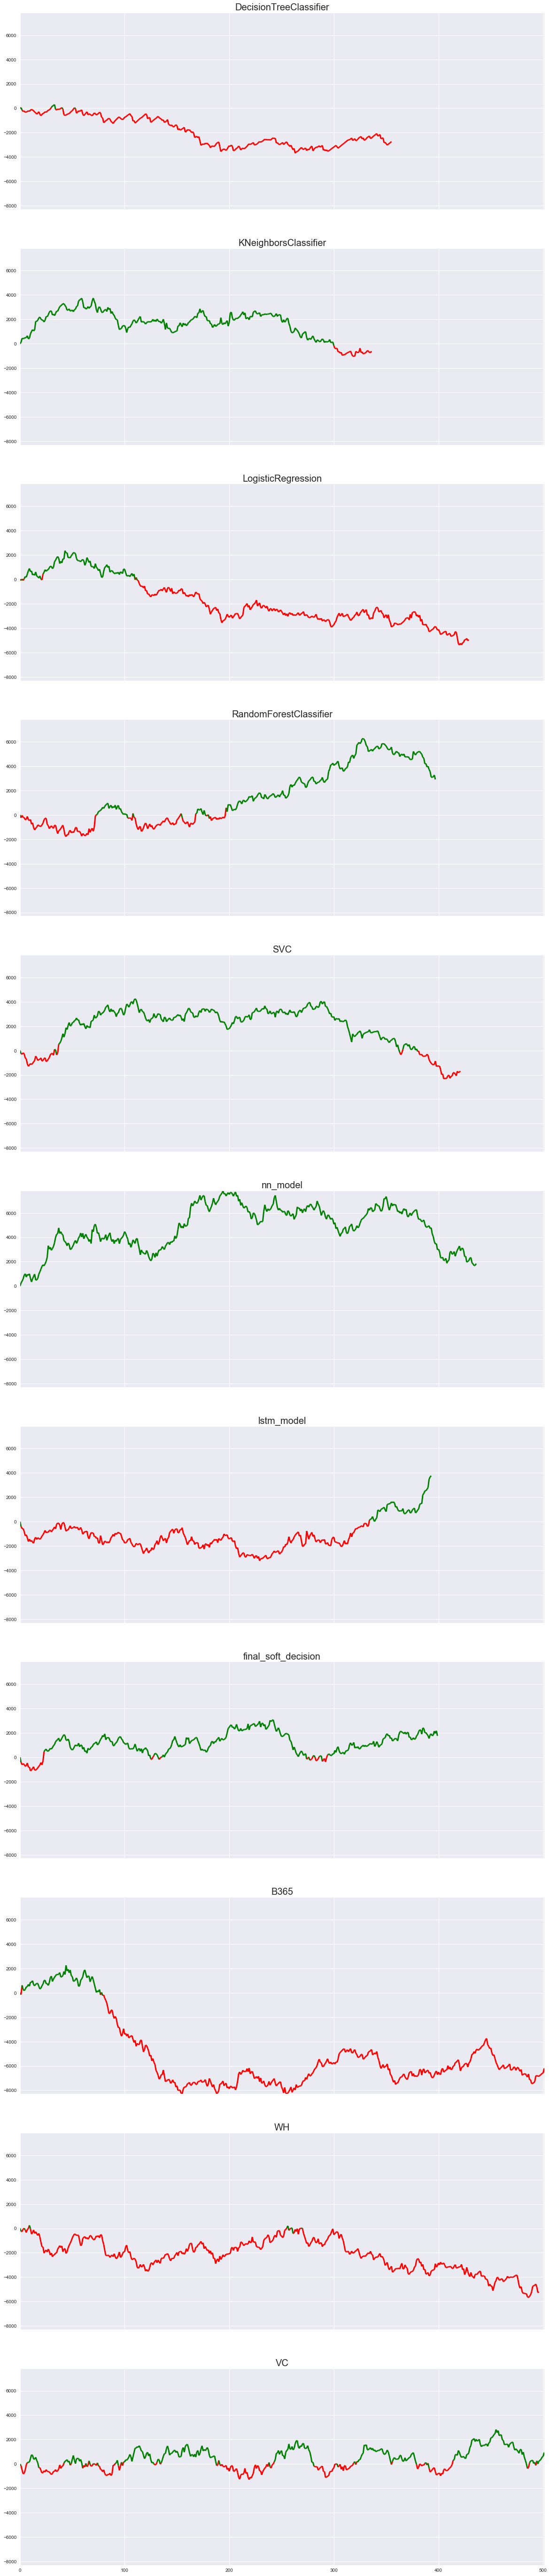

In [812]:
colors = {True:'green', False:'red'}
f, axarr = plt.subplots(len(profit_stat_all_models), 1,figsize=(20, 100), sharex=True, sharey=False)

ymin = ymax = 0
for model in predictions_models_names:
    ymin = min(ymin,all_bets_all_models[model]["profit_through_time"].min())
    ymax = max(ymax,all_bets_all_models[model]["profit_through_time"].max())

for pp,model in enumerate(predictions_models_names):
    temp_df = pd.DataFrame(all_bets_all_models[model]["profit_through_time"],index = all_bets_all_models[model].index, columns=["profit_through_time"] )
    temp_df["sign"] = temp_df["profit_through_time"] >= 0
    temp_df.reset_index(inplace=True)
    
    x = temp_df.as_matrix(columns=["index"])
    x = np.squeeze(x)

    y = temp_df.as_matrix(columns=["profit_through_time"])
    y = np.squeeze(y)
    
    points = np.array([x , y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(y)
    lc.set_linewidth(3)
    axarr[pp].add_collection(lc)
    axarr[pp].set_xlim(x.min(), x.max())
    axarr[pp].set_ylim(ymin, ymax)
    axarr[pp].set_title(model,fontsize = 20)